# Downscaling GADM28 countries and also building continent-level shapes

The [Wilmap](http://dev-wilmap.pantheonsite.io/map) project requires us to construct two javascript files of downscaled polygons for countries, and continents. These shapes must match exactly. The continents must follow the [continent definition](https://en.wikipedia.org/wiki/Boundaries_between_the_continents_of_Earth) that divides Europe and Asia and North and South America.

Currently the wilmap map is generated from two JS files (found in `wilmap/themes/wilmap_theme/dist/source`) of the [project repo](https://github.com/Vizzuality/wilmap), a continent file which is used to render the land-surface, and a country file which is used to paint white lines as borders between them. However, there is a problem in that these shapes have been created in an incompatible way. It looks like currently there were two seperate sources as the orginal shapefiles, which were both simplified to a similar degree. However, the shapefiles were not identical, and consequently the simplification has produced different results. Now the map has an issue in relation to polygon overlap. We need to create new version that are identical at both the country and continent level.



## Procedure

1. Read Admin-0 and Russia Admin-1 shapefiles of GADM28
2. Collapse Russia into two areas (East and West based on continent definition that includes Europe and Asia)
    * Isolate and collect admin-1 shapes in Russia that belong to Asian and European continents, respectively.
    * Using these East- and West- shapes we can recreate a new Russia shape by recombining their geometries into 'new' russia shape.
    * Remove the original Russia shapefile
3. Add the new shapes to a modified version of the gadm28_countries shapefile (also dump un-needed attributes from the table) and export as a shapefile.
    * Also we will need to address a bug with the shapefile at this level wherein South Sudan (and possibly more) countries are missing ISO codes. These should be added to the modified version of the file.
4. Upload the exported shapefile to [MapShaper](http://mapshaper.org/) and simplify the polygons to the desired level, export the simplified data as a shapefile.
5. Import the simplified data back to the notebook, add a column which defines the desired continent grouping of the country shape:
    * Take care to **not assign 'new' Russia**, but to instead assign the east and west divisions you created of Russia to the appropriate continent category.
    * There are also a couple of countries we have noted that you will also need possibly take extra care are correctly assigned, e.g. Cuba, Jamaica. 
6. Use the new column to dissolve the shapefile e.g. `continents = admin0_simplified_shapes.dissolve(by='continent_labels') `
7. Write out both the simplified country shapes and the continent shapes to JSON files. Remove the custom created russian area shapes from the country files after writing, also add in the javascript variable syntax of the original files.


### Resources

* [GADM28 website](http://www.gadm.org/)
* [GADM28 - Russia shapefile](http://www.gadm.org/download)
* [Wilmap API (returns list of continent definitions with countries)](http://dev-wilmap.pantheonsite.io/api/map/browse)



#### Notes
1. What shapes should be in each file? We can answer this question using the Wilmap API link above:
    * We have used these data to construct a dictionary to label the continents of each country shape.
1. The attributes which should be on the shapes for each of the files: 
    * Country file:
        'geometry' + name_engli, iso2, unregion2 (these attributes are directly from the original GAMD28 file)
    * Continent file:
        geometry + 'CONTINENT' {'Africa', 'Asia', 'Central America', 'Europe', 'North America',
       'Oceania', 'South America'}
2. Missing countries are present in the file with a `null` field as the geometry attribute.

#### Further Bugs

1. Caspian sea missing from map  and instead is highlighted as a country (fixed)
2. Russia doesn't highlight on mouseover country name (fixed)
3. Holes in some land borders (Mongolia-Russia, Turkmenistan-Russia) where reconstructed-Russia shape does not match original gadm28 country borders. This is likely due to a disparity in the level of structure detail in gadmn28_countries and russia admin0 shapefiles.
4. Different levels of detail in Russia country shape vs the rest of the world. 
     * A possible future fix for 2./3. is to re-do the whole process but using the Russia geometry from gadmn28_countries instead of the Russia admin-0 file. 




## Read and deal with original data

In [ ]:
## Splitting Russia into Geographic Continents

In [2]:
#Import libs
import geopandas as gpd
import numpy as np
from iso3166 import countries 
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#Download Russia gadm28 shapefiles from http://www.gadm.org/download

In [ ]:
#After unzipping Admin1 map for Russia, read in file
original_rus1 = gpd.read_file('./data/RUS_adm_shp/RUS_adm1.shp')

In [ ]:
#table for Russia at Admin 1 level. We are interested in geometry
original_rus1.head()

In [ ]:
# Find unique fields in a column
original_rus1['NAME_1'].unique()

In [ ]:
#Read in Asia-Europe Geographic Boarder
#This was retreieved using the continents.js file and returning coordinates
#that are common between both the Asia and Europe polygons

eurasian_border = gpd.read_file('./data/eurasia.json')

In [ ]:
#Add buffer to border so that intersecting subregions can be identified

eurasian_border.buffer(0.5).plot()

In [ ]:
#Retrieve polygons from Russian Subregions 

test = original_rus1.geometry.values[0]



In [ ]:
#Define function. If subregion intersects with border return true, else false

def test_area(test):
    if test.intersection(eurasian_border.geometry.values[0].buffer(0.5)):
        return True
    else:
        return False

In [ ]:
#For all admin-1 subregions in russia, store those which intersect with the Asia-Europe boarder to test_area function

intersects = []
for area in original_rus1.geometry.values[0:]:
    intersects.append(test_area(area))

In [ ]:
#Plot subregions which interect with border (in blue)

fig, ax = plt.subplots(figsize=[20,20])
ax.set_aspect('equal')

original_rus1[intersects].plot(ax=ax)
eurasian_border.buffer(0.5).plot(ax=ax, color='blue')
plt.show()

# Dividing Russia at admin-1 level

Now we can loop through all russian admin-1 regions and separate into two groups: those belonging to Asia and Europe. The simplest way to do this is to inspect the centroid of each subregion.

If the longitude of that centroid is greater than that of the western-most subregion in Asia (pale green region to the right of the border, seen above) then it must fall in asia. If not, then europe.

In [ ]:
#List all admin-1 centroids, in descending order.
#Here, using .xy to show the longitude of each centroids coordinate.
#Since .xy returns a tuple of two arrays, .xy[0][0] gives longitude, .xy[1][0] give latitude

centroids = original_rus1[intersects].geometry.centroid

sorted([centroid.xy[0][0] for centroid in centroids if centroid.xy[0]], reverse=True)


In [ ]:
#Isolate the 4 subregions to the east of the borderline to define Asia's western edge
#Find the 4 rows with the most easterly centroids
# the lowest value of longitude is our minimum requirement for being in Asia (long>60 in this case)

for centroid in centroids:
    if centroid.xy[0][0] > 60:
        print('True for', centroid.xy[0][0])
        

In [ ]:
#Now we have a way of finding the dividing border we can create
#an algorithm to produce an East-West Continental divide through Russia

#First function identifes if a subregion interescts with the boarder region

def intersecting_area(test):
    if test.intersection(eurasian_border.geometry.values[0].buffer(0.5)):
        return True
    else:
        return False

#If this is True, those subregions with a centroid greater than 60deg return true
# and false if less than 60deg

def intersecting_in_east(test): 
    if test.centroid.xy[0][0] > 60:
        return True
    else:
        return False
    
#Of those that do not intersect the boarder, return true if east of the boarder
# (and in the eastern hemisphere!), otherwise return false

def east(test):
    if test.centroid.xy[0][0] > 0 and test.centroid.xy[0][0] < 60:
        return False
    else:
        return True
    


In [ ]:
#Create a continent list to assign subregions the continental definition East or West and apply algorithm

continent_list = []

for n in original_rus1.index:
    tmp_geom = original_rus1.geometry[n]
    #print(n, tmp_geom.centroid)
    if intersecting_area(tmp_geom):
        #print('in condition')
        if intersecting_in_east(tmp_geom):
            continent_list.append('Asia')
        else:
            continent_list.append('Europe')
    else:
        if east(tmp_geom):
            continent_list.append('Asia')
        else:
            continent_list.append('Europe')

    


In [ ]:
#Check length of lists to make sure it matches original 
len(continent_list), len(original_rus1)

In [ ]:
#Append 'Continent' definition list as a new column in the original Russia .shp data
original_rus1['Continent'] = continent_list

In [ ]:
# joining shapes based on an attribute column - can make this a country shape thing
split_russia = original_rus1.dissolve(by='Continent')
split_russia.head()

In [ ]:
#Check continental split! Red = Europe, Blue = Asia
split_russia.plot(figsize=(20,20))

In [ ]:
#Get other countries from GADM28 countries shapefile and add split_russia

In [ ]:
# You will need to uncompress the countries shapefile first

!ls ./data/gadm28_countries.zip

In [ ]:
original_gadm28 = gpd.read_file('./data/gadm28_countries/gadm28_countries.shp')

In [ ]:
#Check to see that we have the data needed for each country

original_gadm28.head()

In [ ]:
#Find Russia's Details
ru_mask = original_gadm28['iso2'] == 'RU'
original_gadm28[ru_mask]

In [ ]:
#Check to see if admin0 and admin1 shapes match with gadam28 shapes

ru_mask = original_gadm28['iso2'] == 'RU'
original_gadm28[ru_mask].geometry

fig, ax = plt.subplots(figsize=[20,20])
ax.set_aspect('equal')

original_gadm28[ru_mask].geometry.plot(ax=ax)
split_russia.plot(ax=ax, color='blue', alpha = 0.3)
plt.xlim(30,100)
plt.show()

In [ ]:
#Split_Russia shapes need to be added back. 
#Note that they require the same keys as the other countries.

tmp_data=[['Asia',split_russia.geometry.values[0],None,'XE',None],
          ['Europe',split_russia.geometry.values[1],None,'XW',None]]

cnames=['unregion2','geometry','name_engli','iso2','unregion1']

new_russia = gpd.GeoDataFrame(tmp_data, columns=cnames)

In [ ]:
#Append New Russia shapes to existing countries

new_countries = original_gadm28[["name_engli","iso2","unregion2",'unregion1', 'geometry']].append(new_russia)
new_countries.tail()

In [ ]:
#remove Original Russia Shape from gadm28 countries (we dont need it twice!)
russia_mask = original_gadm28['iso'] != 'RUS'
original_gadm28 = original_gadm28[russia_mask]

In [ ]:
#Rename iso2 for South Sudan, Kosovo, Northern Cyprus

mask_ss = new_countries['name_engli'] == 'South Sudan'
new_countries[mask_ss]

new_countries['iso2'][155] = 'SS' 

In [ ]:
mask_ss = new_countries['name_engli'] == 'Northern Cyprus'
new_countries[mask_ss]

new_countries['iso2'][68] = 'XC' 


In [ ]:
mask_ss = new_countries['name_engli'] == 'Kosovo'
new_countries[mask_ss]

new_countries['iso2'][206] = 'XK' 

In [ ]:
#remove caspian... its not a country!
caspian_mask = new_countries['name_engli'] != 'Caspian Sea'
new_countries = new_countries[caspian_mask]

In [ ]:
#Make new directory and save new countryfile that includes Split Russia shapes (XE,XW)

In [ ]:
!mkdir ./data/new_countries

In [ ]:
new_countries.to_file(driver = 'ESRI Shapefile', filename = './data/new_countries/new_countries.shp')

In [ ]:
#Upload to mapshaper and downscale together: weighted area/66%

# Mapshaper Reduced resolution Data After This Section


## Country file

Output js file with only countries of interest 

Country file: 'geometry', name_engli, iso2, unregion2 (these attributes are directly from the original GAM

In [3]:
#Read in simplified countries
df_countries = gpd.read_file("./data/new_simplified_countries/new_simplified_countries.shp")

In [4]:
#Check contents
df_countries.head()

,geometry,iso2,name_engli,unregion1,unregion2
0,(POLYGON ((15.72968769073498 68.97135162353516...,NO,Norway,Northern Europe,Europe
1,None,TK,Tokelau,Polynesia,Oceania
2,"POLYGON ((100.0867691040041 20.35089111328153,...",TH,Thailand,South-Eastern Asia,Asia
3,"POLYGON ((-59.98764038085931 8.53045463562006,...",VE,Venezuela,South America,Americas
4,"POLYGON ((13.6345472335816 13.71068859100347, ...",NG,Nigeria,Western Africa,Africa


In [5]:
#Combine XE and XW into RU

In [6]:
#Crate new dataframe containing only east- and west-russia
tmp_ew = df_countries[-2:]
tmp_ew['GROUP'] = [1,1]

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [7]:
tmp_ew

,geometry,iso2,name_engli,unregion1,unregion2,GROUP
254,(POLYGON ((142.7081604003906 54.42454910278326...,XE,None,None,Asia,1
255,(POLYGON ((22.76914024353056 54.37712860107422...,XW,None,None,Europe,1


In [8]:
#Create new Russia country shape by dissolving over common attribute 'GROUP' and check
rus = tmp_ew.dissolve(by='GROUP')  
rus

,geometry,iso2,name_engli,unregion1,unregion2
GROUP,,,,,
1,(POLYGON ((164.5908355712893 59.23646545410156...,XE,None,None,Asia


In [9]:
#Create a new dataframe that is compatible with the other countries

russia = gpd.GeoDataFrame([[rus.geometry.values[0],'RU', 'Russia', 'Europe']],
                          columns=['geometry','iso2', 'name_engli','unregion2'])
russia

,geometry,iso2,name_engli,unregion2
0,(POLYGON ((164.5908355712893 59.23646545410156...,RU,Russia,Europe


In [ ]:
#Drop unnecessary attribute column in df_countries
df_countries = df_countries.drop(['unregion1'], axis=1)

In [10]:
#Drop East and West Russia from df_countries
mask_ss = [iso not in ['XE','XW'] for iso in df_countries['iso2'] ]
df_coun = df_countries[mask_ss]

In [11]:
#Check they're removed
print(len(df_coun))
df_coun.tail()

254


,geometry,iso2,name_engli,unregion2
249,"POLYGON ((16.58431243896484 46.47904968261724,...",SI,Slovenia,Europe
250,(POLYGON ((161.348617553711 -10.19083213806141...,SB,Solomon Islands,Oceania
251,POLYGON ((31.30727577209478 -22.42027664184553...,ZA,South Africa,Africa
252,(POLYGON ((124.476043701172 -9.174028396606216...,TL,East Timor,Asia
253,POLYGON ((32.95349884033232 -9.401408195495492...,ZM,Zambia,Africa


In [12]:
#Now replace Eat- and West-Russia with teh unified Russia
df_coun = df_coun.append(russia, ignore_index=True)

print(len(df_coun))

df_coun.tail()

255


,geometry,iso2,name_engli,unregion2
250,(POLYGON ((161.348617553711 -10.19083213806141...,SB,Solomon Islands,Oceania
251,POLYGON ((31.30727577209478 -22.42027664184553...,ZA,South Africa,Africa
252,(POLYGON ((124.476043701172 -9.174028396606216...,TL,East Timor,Asia
253,POLYGON ((32.95349884033232 -9.401408195495492...,ZM,Zambia,Africa
254,(POLYGON ((164.5908355712893 59.23646545410156...,RU,Russia,Europe


In [14]:
iso_present = []
for n, iso in enumerate(df_coun['iso2']):
    if iso == None:
        print(df_coun['iso2'][n], df_coun['name_engli'][n])
        iso_present.append(False)
    else:
        iso_present.append(True)

# remove all rows without isos at this point

None Clipperton Island
None Paracel Islands
None Saint-Martin
None Spratly islands
None Akrotiri and Dhekelia
None Sint Maarten
None Saint-Barthélemy
None Curaçao


In [15]:
df_coun = df_coun[iso_present]
len(df_coun)

247

In [16]:
df_coun['iso2'].unique()  # check no 'none' values remain. NOte RU for russia is added, and XW/XE removed

array(['NO', 'TK', 'TH', 'VE', 'NG', 'AR', 'EH', 'NP', 'BR', 'FI', 'MC',
       'ID', 'US', 'PG', 'AU', 'MY', 'CC', 'MX', 'CL', 'BD', 'SE', 'WF',
       'CH', 'NF', 'BB', 'CA', 'IR', 'KR', 'LI', 'VN', 'CN', 'JP', 'NL',
       'AD', 'PM', 'CD', 'DM', 'KN', 'IM', 'CU', 'TR', 'IN', 'GI', 'IT',
       'GR', 'AI', 'AQ', 'SJ', 'MM', 'SM', 'IO', 'PH', 'VA', 'TN', 'GW',
       'GU', 'HM', 'ZW', 'CX', 'MA', 'GF', 'PT', 'MD', 'XC', 'AE', 'YT',
       'BV', 'NU', 'PK', 'AW', 'TZ', 'SA', 'GL', 'SC', 'LT', 'BO', 'SL',
       'SV', 'GD', 'JE', 'TV', 'TO', 'EE', 'DK', 'LA', 'SR', 'CM', 'GG',
       'FK', 'BG', 'KP', 'KH', 'SO', 'TG', 'MU', 'NE', 'SY', 'PL', 'NA',
       'GS', 'BF', 'IQ', 'DJ', 'RO', 'AM', 'PS', 'GE', 'TT', 'LC', 'DZ',
       'PR', 'LR', 'CG', 'RS', 'RE', 'BY', 'GQ', 'CF', 'AZ', 'KW', 'MW',
       'AS', 'NR', 'AT', 'TC', 'JM', 'UG', 'TD', 'AN', 'AO', 'BZ', 'KY',
       'AG', 'VC', 'UM', 'KG', 'LV', 'KE', 'HN', 'ER', 'MO', 'AF', 'LK',
       'BH', 'BA', 'SS', 'GH', 'QA', 'BM', 'BW', 'H

In [17]:
# write out js file here
countries_json = df_coun.to_json()

with open('./data/gadm28_countries.js','w') as f:
    f.write('var geoCountries = ')
    f.write(countries_json)

In [18]:
!ls ./data/gadm28_countries.js -lh

-rw-r--r-- 1 jovyan jovyan 584K Oct 20 12:07 ./data/gadm28_countries.js


## Generate Continent file


In [19]:
#Again, read in simplified country shapes
df_countries = gpd.read_file("./data/new_simplified_countries/new_simplified_countries.shp")

In [20]:
#Add the following carribean countries visible on map to Central American Continent
countries.get('Puerto Rico'), countries.get('Cuba'), countries.get('Jamaica'), countries.get('Bahamas'), countries.get('Haiti'), countries.get('Dominican Republic'), countries.get('Trinidad and Tobago')

(Country(name='Puerto Rico', alpha2='PR', alpha3='PRI', numeric='630', apolitical_name='Puerto Rico'),
 Country(name='Cuba', alpha2='CU', alpha3='CUB', numeric='192', apolitical_name='Cuba'),
 Country(name='Jamaica', alpha2='JM', alpha3='JAM', numeric='388', apolitical_name='Jamaica'),
 Country(name='Bahamas', alpha2='BS', alpha3='BHS', numeric='044', apolitical_name='Bahamas'),
 Country(name='Haiti', alpha2='HT', alpha3='HTI', numeric='332', apolitical_name='Haiti'),
 Country(name='Dominican Republic', alpha2='DO', alpha3='DOM', numeric='214', apolitical_name='Dominican Republic'),
 Country(name='Trinidad and Tobago', alpha2='TT', alpha3='TTO', numeric='780', apolitical_name='Trinidad and Tobago'))

In [21]:
#Create list iso2 codes

C_to_c = {"Africa": ["DZ","AO","BJ","BW","BF","BI","CM","CV","CF","TD","KM","CD","DJ","GQ","EG","ER","ET",
            "GA","GM","GH","GN","GW","CI","KE","LS","LR","LY","MG","MW","ML","MR","MU","YT",
            "MA","MZ","NA","NE","NG","CG","RE","RW",
            "SH","ST","SN","SC","SL","SO","ZA","SS","SD","SZ","TZ","TG","TN","UG","EH","ZM","ZW"],
 "Asia": ["AF","AM","AZ","BH","BD","BT","IO","BN","KH","CN","CX","CC","CY","TL","GE",
          "HK","IN","ID","IR","IQ","IL","JP","JO","KZ","KW","KG","LA","LB","MO","MY","MV",
          "MN","MM","NP","KP","OM","PK","PS","PH","QA","SA","SG","KR","LK","SY","TW","TJ","TH",
          "TR","TM","AE","UZ","VN","YE","XE","XC"],
"Central America": ["BZ","CR","SV","GT","HN","NI","PA","PR","CU","JM","BS","HT","DO","TT"],
"Europe": ["AL","AD","AT","BY","BE","BA","BG","XX","HR","CZ","DK","EE","FO","FI","FR","DE",
             "GI","GR","HU","IS","IE","IT","XK","LV","LI","LT","LU","MK","MT","MD","MC","ME","NL","NO",
             "PL","PT","RO","SM","RS","SK","SI","ES","SJ","SE","CH","UA","GB","VA","XW","XK"],
"North America": ["BM","CA","GL","MX","PM","US"],
"Oceania": ["AS","AU","CK","FJ","PF","GU","KI","MH","FM","NR","NC","NZ","NU","NF","MP",
 "PW","PG","PN","WS","SB","TK","TO","TV","UM","VU","WF"],
"South America": ["AR","BO","BR","CL","CO","EC","FK","GF","GY","PY","PE","SR","UY","VE"]}


d = {}
for key in C_to_c.keys():
    for c in C_to_c[key]:
        d[c] = key

In [22]:
#Attribute a continent to a country that has none

continent_id = []
for n, iso in enumerate(df_countries.iso2):
    try:
        if iso in ["PR","CU","JM","BS","HT","DO","TT"]:
            print('True for',iso)
            #continent_id.append("North America")
            continent_id.append('Central America')
        else:
            continent_id.append(d[iso])
    except:
        continent_id.append(None)


True for CU
True for TT
True for PR
True for JM
True for HT
True for DO
True for BS


In [23]:
#Print end needs attribute column called 'CONTINENT'

In [24]:
df_countries['CONTINENT'] = continent_id
df_countries.head() #[np.array(continent_id) == None]

,geometry,iso2,name_engli,unregion1,unregion2,CONTINENT
0,(POLYGON ((15.72968769073498 68.97135162353516...,NO,Norway,Northern Europe,Europe,Europe
1,None,TK,Tokelau,Polynesia,Oceania,Oceania
2,"POLYGON ((100.0867691040041 20.35089111328153,...",TH,Thailand,South-Eastern Asia,Asia,Asia
3,"POLYGON ((-59.98764038085931 8.53045463562006,...",VE,Venezuela,South America,Americas,South America
4,"POLYGON ((13.6345472335816 13.71068859100347, ...",NG,Nigeria,Western Africa,Africa,Africa


In [25]:
#Check no. of countries
len(continent_id),len(df_countries)

(256, 256)

In [26]:
#Remove countries with no continent
mask_out_nones = df_countries['CONTINENT'] != None
tmp_ = df_countries[mask_out_nones]

In [27]:
#Remove countries with no geometry
mask_for_geoms = [geom != None for geom in tmp_.geometry.values]
tmp_2 = tmp_[mask_for_geoms]
tmp_2.head()

,geometry,iso2,name_engli,unregion1,unregion2,CONTINENT
0,(POLYGON ((15.72968769073498 68.97135162353516...,NO,Norway,Northern Europe,Europe,Europe
2,"POLYGON ((100.0867691040041 20.35089111328153,...",TH,Thailand,South-Eastern Asia,Asia,Asia
3,"POLYGON ((-59.98764038085931 8.53045463562006,...",VE,Venezuela,South America,Americas,South America
4,"POLYGON ((13.6345472335816 13.71068859100347, ...",NG,Nigeria,Western Africa,Africa,Africa
5,(POLYGON ((-68.61051177978516 -54.894306182861...,AR,Argentina,South America,Americas,South America


In [28]:
# rough example of the concept necessary to build the continents from the country file:
# Way of creating a copy of a dataframe and reducing the columns present, then show how to unify by a column

continents = tmp_2.dissolve(by='CONTINENT')  # joining shapes based on an attribute column - can make this a country shape thing
continents.head()

,geometry,iso2,name_engli,unregion1,unregion2
CONTINENT,,,,,
Africa,(POLYGON ((57.61097335815452 -19.9809703826903...,NG,Nigeria,Western Africa,Africa
Asia,(POLYGON ((119.934997558594 -9.275830268859863...,TH,Thailand,South-Eastern Asia,Asia
Central America,(POLYGON ((-60.93902587890619 10.8443069458007...,CU,Cuba,Caribbean,Americas
Europe,(POLYGON ((-15.41930484771729 28.1820831298831...,NO,Norway,Northern Europe,Europe
North America,(POLYGON ((-157.9833374023436 21.7111110687258...,US,United States,Northern America,Americas


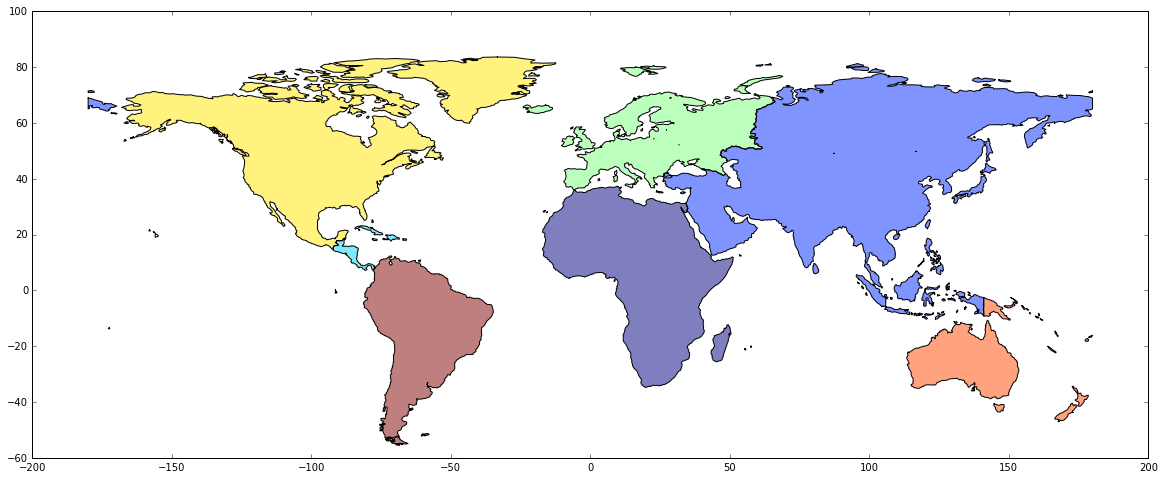

In [29]:
#check that the continents look correct!
continents.plot(figsize=(20,20))

In [30]:
#Now put the continent data into an appropriate data structure

continent_for_output = gpd.GeoDataFrame(continents.index.values, columns=['CONTINENT'],
                                        geometry=continents.geometry.values)

In [31]:
#Add centroid and zoom attributes
continent_for_output

,CONTINENT,geometry
0,Africa,(POLYGON ((57.61097335815452 -19.9809703826903...
1,Asia,(POLYGON ((119.934997558594 -9.275830268859863...
2,Central America,(POLYGON ((-60.93902587890619 10.8443069458007...
3,Europe,(POLYGON ((-15.41930484771729 28.1820831298831...
4,North America,(POLYGON ((-157.9833374023436 21.7111110687258...
5,Oceania,(POLYGON ((167.8694458007813 -46.6836128234862...
6,South America,(POLYGON ((-68.70249938964821 -55.149307250976...


In [32]:
#Create a list of centroids for each continent

continent_coords = continent_for_output.geometry.centroid
tmp_coords = []
for centroid in continent_coords:
    tmp_coords.append([centroid.xy[0][0], centroid.xy[1][0]])
tmp_coords

[[18.28460154096003, 6.430399240054449],
 [95.63247231666449, 45.34251404523374],
 [-82.9562550907045, 15.20239321094113],
 [28.076526846466454, 55.799638688178504],
 [-92.46111753951266, 57.24275592459956],
 [136.57919586132738, -25.38548872902159],
 [-60.74598208384878, -15.071475436130527]]

In [33]:
#Add columns to continent dataframe. Note that zoom levels are chosen so that the continent fits the screen

continent_for_output['centroid'] = tmp_coords
continent_for_output['zoom'] = [3,3,4,3,3,5,4]

continent_for_output

,CONTINENT,geometry,centroid,zoom
0,Africa,(POLYGON ((57.61097335815452 -19.9809703826903...,"[18.28460154096003, 6.430399240054449]",3
1,Asia,(POLYGON ((119.934997558594 -9.275830268859863...,"[95.63247231666449, 45.34251404523374]",3
2,Central America,(POLYGON ((-60.93902587890619 10.8443069458007...,"[-82.9562550907045, 15.20239321094113]",4
3,Europe,(POLYGON ((-15.41930484771729 28.1820831298831...,"[28.076526846466454, 55.799638688178504]",3
4,North America,(POLYGON ((-157.9833374023436 21.7111110687258...,"[-92.46111753951266, 57.24275592459956]",3
5,Oceania,(POLYGON ((167.8694458007813 -46.6836128234862...,"[136.57919586132738, -25.38548872902159]",5
6,South America,(POLYGON ((-68.70249938964821 -55.149307250976...,"[-60.74598208384878, -15.071475436130527]",4


In [34]:
continent_json = continent_for_output.to_json()

with open('./data/continent.js','w') as f:
    f.write('var geoContinents = ')
    f.write(continent_json)

In [35]:
!ls ./data/continent.js -lrth

-rw-r--r-- 1 jovyan jovyan 273K Oct 20 12:08 ./data/continent.js
